# Covid-19 infección en Ecuador. Modelos probabilisticos
Implementacion de un modelo probabilistico de infección por el virus Covid-19

Se realiza un análisis probabilistico simple del crecimiento de la infección en Python y el modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de probabilidad.

In [91]:
# Importar las librerias para el analasis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from random import randrange
%matplotlib inline
import pygame


In [92]:
# Actualizar los datos (URL)
url = 'https://covid.ourworldindata.org/data/ecdc/new_cases.csv'
df = pd.read_csv(url)
df

,date,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
0,2019-12-31,27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2020-01-03,17,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2020-01-04,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,2020-11-12,623536,146.0,507.0,811.0,90.0,136.0,0.0,0.0,10880.0,...,224.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,39.0,57.0
318,2020-11-13,646171,360.0,410.0,851.0,49.0,137.0,0.0,0.0,11162.0,...,220.0,0.0,0.0,695.0,1.0,0.0,0.0,0.0,0.0,29.0
319,2020-11-14,628489,66.0,490.0,867.0,109.0,104.0,0.0,2.0,11859.0,...,63.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,57.0,69.0
320,2020-11-15,589885,205.0,532.0,844.0,0.0,171.0,0.0,1.0,8468.0,...,0.0,0.0,0.0,301.0,9.0,0.0,0.0,0.0,4.0,21.0


Imprimos los resultados y agregamos el numero del dia


In [93]:
df = df.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df

,date,Ecuador
0,-1,0.0
1,0,0.0
2,1,0.0
3,2,0.0
4,3,0.0
...,...,...
317,316,919.0
318,317,883.0
319,318,1161.0
320,319,953.0


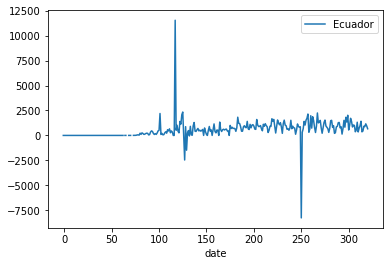

In [94]:
df.plot(x ='date', y='Ecuador')

Ahora podemos analizar un modelo probabilisto para el examen.

## El modelo basado en probabilidad

Para realizar un estimacion del factor de crecimiento de los casos de Covid 19 en Ecuador calculamos la mediana, con esto obtenemo el valor medio de crecimiento de un conjunto de datos, con esto podemos obtener un factor de crecimiento o taza de crecimiento de los nuevos casos.



In [95]:
filtro = df["Ecuador"][61:] # Filtro los datos que se empezo a tener casos
#Obtenemos la mediana
media = filtro.mean()
mediana = filtro.median()
print(mediana)
print(media)


666.5
704.27734375


De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»


In [96]:
#Vamos a comprobar:
# según la media y la mediana podemos obtener la taza de crecieminto y predicir su comportamiento.
# Cargamos los datos de total de casos
url = 'https://covid.ourworldindata.org/data/ecdc/total_cases.csv'
df_t = pd.read_csv(url)
df_t = df_t.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
FMT = '%Y-%m-%d'
date = df_t['date']

df_t['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
#df_t = df_t.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
#Investiga dropa
df_t=df_t.dropna()
dias = list(df_t['date'])

y = list(df_t.iloc [:, 1]) # Total casos
x = list(df_t.iloc [:, 0]) # Dias
#Realizamos un ejemplo de prediccion
prediccion_siguiente = int(y[-1] + mediana)
print(prediccion_siguiente)

180961


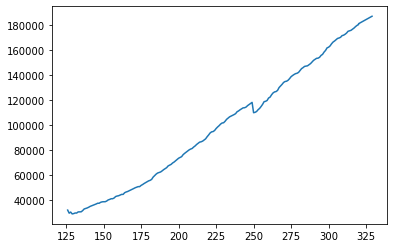

In [97]:
# Quiero predecir cuántos "Casos" voy a obtener de aqui a 10 dias.
for i in range(x[-1], x[-1]+10):
    x.append(i)
    y.append(int(y[-1] + mediana))
plt.plot(x[61:], y[61:])
plt.show()

# Practica

1. Comparar el modelo de predicion matematico vs probabilidad.
2. Generar el SIR en base al modelo de probabilidad y obtener beta y gamma con una semana de prediccion.
3. Retroceder un semana y comparar el modelo matematico vs probabilidad vs reales. Solo cargan los datos para generar los modelos menos 7 dias.

Puntos extras: Investigas sobre la correlacion de variables y aplicar el calculo en base a los datos del Ecuador.

# 1. Comparar el modelo de predicion matematico vs probabilidad.

In [104]:
def func(x, c0, c1, c2, c3):
    return c0 * np.exp(-c1 * x) + c2 + c3

In [105]:
g = [100, 0.01, 200, 0.01]
n = len(x[61:])
y = np.empty(n)
for i in range(n):
    y[i] = func(x[i], g[0], g[1], g[2], g[3])

<ipython-input-104-9be5e1285112>:2: RuntimeWarning:

overflow encountered in exp

<ipython-input-104-9be5e1285112>:2: RuntimeWarning:

overflow encountered in multiply



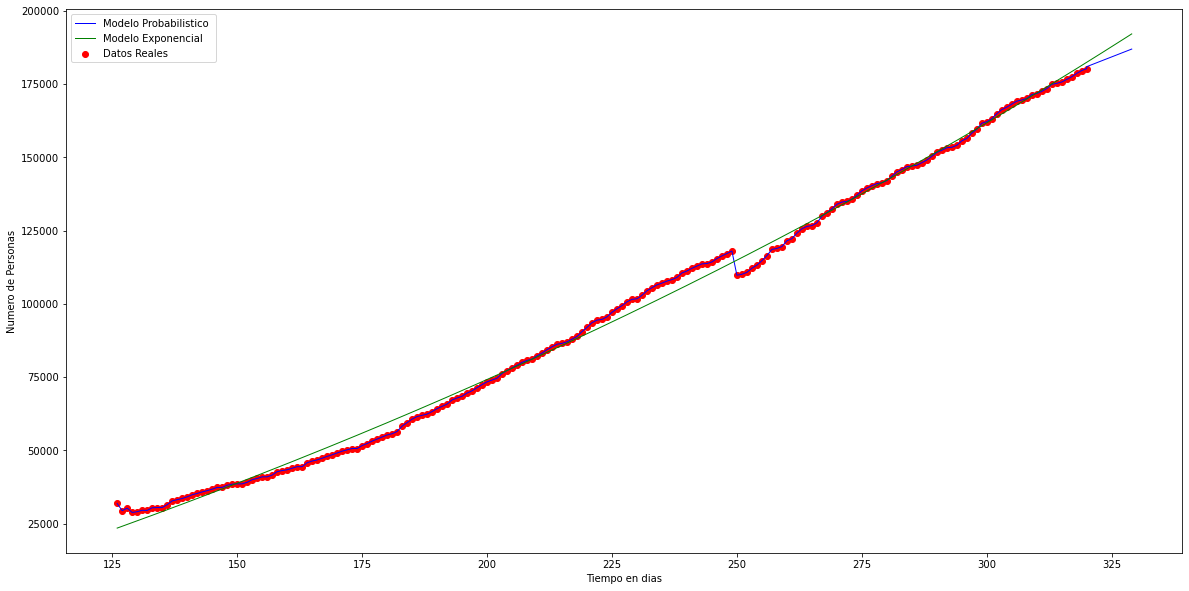

In [106]:
#Modelo Probabilidad
y1 = list(df_t.iloc [:, 1]) # Total casos
x1 = list(df_t.iloc [:, 0]) # Dias
#Prediccion 10 dias
for i in range(x1[-1], x1[-1]+10):
    x1.append(i)
    y1.append(int(y1[-1] + mediana))

#Modelo exponencial
yy = list(df_t.iloc [:, 1]) # Total casos
xx = list(df_t.iloc [:, 0]) # Dias
casos = list(df_t.iloc [:, 1])# Total casos
dias = list(df_t.iloc [:, 0]) # Dias

popt, pcov = curve_fit(func, dias[61:], casos[61:], g)
for i in range(n):
    casos[i] = func(dias[i], popt[0], popt[1], popt[2], popt[3])


#Predecir para 10 dias
pred_x = np.array(list(range(min(dias[61:]),max(dias[61:])+10)))
#  Grafica 1
fig = go.Figure()

fig.add_trace(go.Scatter(y=yy[61:],x=xx[61:],mode='markers',name='Datos Reales'))
fig.add_trace(go.Scatter(y=func(pred_x,*popt),x=pred_x,mode='lines',name='Modelo Exponencial'))
fig.add_trace(go.Scatter(y=y1[61:],x=x1[61:],mode='lines',name='Modelo Probabilistico'))

fig.show()
xa=t[0:len(y)]
#  Grafica 2
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(x1[61:], y1[61:], 'b', alpha=1, lw=1, label='Modelo Probabilistico ')
ax.plot(pred_x, func(pred_x,*popt), 'g', alpha=1, lw=1, label='Modelo Exponencial')
ax.scatter(xx[61:], yy[61:],label="Datos Reales",color="red")
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')

legend = ax.legend()

# 2. Generar el SIR en base al modelo de probabilidad y obtener beta y gamma con una semana de prediccion.

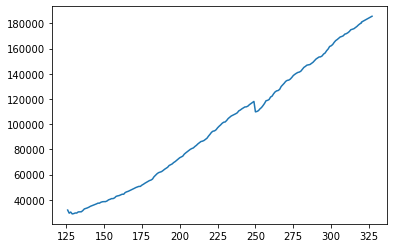

In [107]:
y0 = list(df_t.iloc [:, 1]) # Total casos
x0 = list(df_t.iloc [:, 0]) # Dias
#modelo de probabilidad 
#semana de prediccion.
for i in range(x0[-1], x0[-1]+8):
    x0.append(i)
    y0.append(int(y0[-1] + mediana))
plt.plot(x0[61:], y0[61:])
plt.show()
dias=x0[61:]
data=y0[61:]

Valor de Beta  0.03999999110395448
Valor de Gamma  1e-08
Valor de R0  3999999.1103954483


ValueError: x and y must have same first dimension, but have shapes (100,) and (203,)

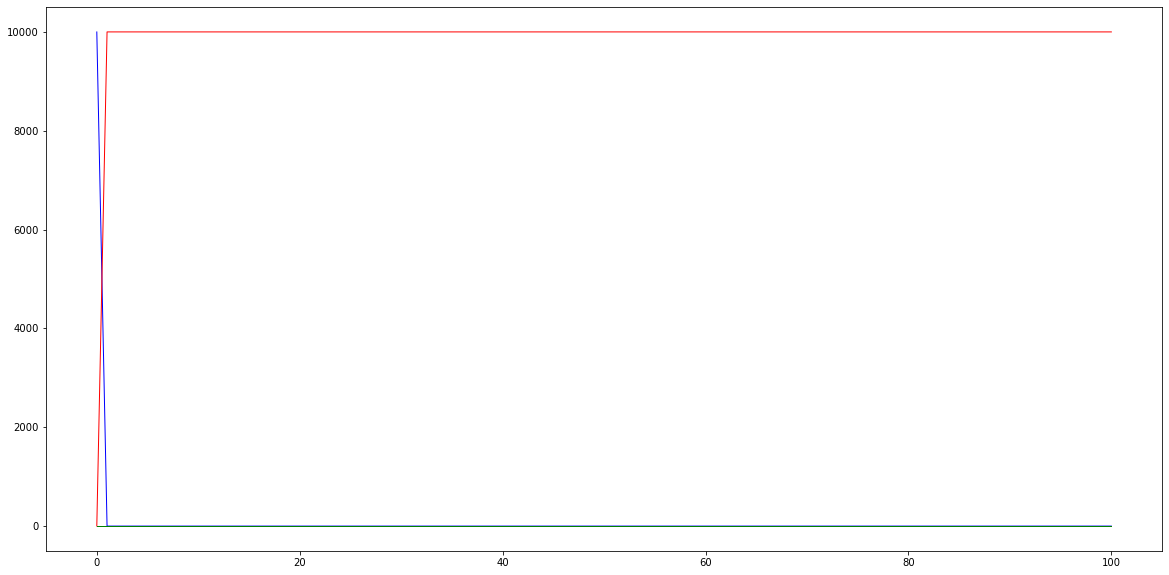

In [108]:
#Modelo SIR
# 3. Implementar teniendo en cuenta los casos confirmados y recuperados.
def loss(point, datos, s0, i0, r0):
    size = len(datos)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s0,i0,r0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - datos)**2))

#Numero habitantes del Ecuador
N=10000
#casos confirmados
i0=1
#Recuperados
r0=0
#Resto de la poblacion
s0= N - i0 - r0

x = dias
y = data
datos=data

optimal = minimize(loss, [0.001, 0.001], args=(datos,s0,i0, r0), method='L-BFGS-B', bounds=[(0.00000001,0.04), (0.00000001, 0.04)])   
beta, gamma = optimal.x
R00=(beta/gamma)

print('Valor de Beta ',beta)
print('Valor de Gamma ',gamma)
print('Valor de R0 ',R00) 

new_index =y
size = len(new_index)
ea = np.concatenate((y, [None] * (size - len(y))))
t = np.linspace(0, 100, 100)
# Las ecuaciones diferenciales del modelo SIR..
def deriv(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I 
    dIdt = beta * S * I  - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Vector de condiciones iniciales
y0 = s0,i0,r0

# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(deriv, y0, t, args=(beta, gamma))
S, I, R = ret.T # Obtenicion de resultados
xa=t[0:len(y)]

#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=1, lw=1, label='Sustible de infeccion')
ax.plot(t, I, 'r', alpha=1, lw=1, label='Infectados')
ax.plot(t, R, 'g', alpha=1, lw=1, label='Recuperados')
ax.plot(xa, ea, 'y', alpha=1, lw=1, label='confirmados')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')
legend = ax.legend()

# 3. Retroceder un semana y comparar el modelo matematico vs probabilidad vs reales. Solo cargan los datos para generar los modelos menos 7 dias.

In [ ]:
def func(x, c0, c1, c2, c3):
    return c0 * np.exp(-c1 * x) + c2 + c3
g = [100, 0.01, 200, 0.01]
n = len(x[61:])
y = np.empty(n)
for i in range(n):
    y[i] = func(x[i], g[0], g[1], g[2], g[3])
    
#Modelo Probabilidad
y1 = list(df_t.iloc [:, 1][:103]) # Total casos
x1 = list(df_t.iloc [:, 0][:103]) # Dias
y_real = list(df_t.iloc [:, 1]) # Total casos
x_real = list(df_t.iloc [:, 0]) # Dias

#Prediccion 10 dias
for i in range(x1[-1], x1[-1]+8):
    x1.append(i)
    y1.append(int(y1[-1] + mediana))

#Modelo exponencial
yy = list(df_t.iloc [:, 1][:103]) # Total casos
xx = list(df_t.iloc [:, 0][:103]) # Dias
casos = list(df_t.iloc [:, 1][:103])# Total casos
dias = list(df_t.iloc [:, 0][:103]) # Dias

popt, pcov = curve_fit(func, dias[61:], casos[61:], g)
for i in range(n):
    casos[i] = func(dias[i], popt[0], popt[1], popt[2], popt[3])


#Predecir para 10 dias
pred_x = np.array(x_real[61:])

print("Modelo Probabilistico ")
print("Prediccion en 7 dias =: ",*y1[61:][-1:])
print("")
print("Modelo Exponencial ")
print("Prediccion en 7 dias =: ",int(func(pred_x,*popt)[-1:]))
print("")
print("Datos Reales")
print("En 7 dias =: ",*y_real[61:][-1:])
fig = go.Figure()

fig.add_trace(go.Scatter(y=y_real[61:],x=x_real[61:],mode='markers',name='Datos Reales'))
fig.add_trace(go.Scatter(y=func(pred_x,*popt),x=pred_x,mode='lines',name='Modelo Exponencial'))
fig.add_trace(go.Scatter(y=y1[61:],x=x1[61:],mode='lines',name='Modelo Probabilistico'))

fig.show()

# Grafica
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111,  axisbelow=True)
ax.scatter(x_real[61:], y_real[61:],label="Datos Reales",color="red")
ax.plot(x1[61:], y1[61:], 'b', alpha=1, lw=1, label='Modelo Probabilistico ')
ax.plot(pred_x, func(pred_x,*popt), 'g', alpha=1, lw=1, label='Modelo Exponencial')

ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')
legend = ax.legend() 

## Analisis

## Conclusiones

## Criterio personal (politico, economico y  social de la situacion)



# Referencias

- https://www.researchgate.net/publication/340092755_Infeccion_del_Covid-19_en_Colombia_Una_comparacion_de_modelos_logisticos_y_exponenciales_aplicados_a_la_infeccion_por_el_virus_en_Colombia

- https://www.aprendemachinelearning.com/regresion-lineal-en-espanol-con-python/